<center><font size="+3"><strong>Predicting Apartment Prices in Mexico City</strong></font></center>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from glob import glob

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
from category_encoders import OneHotEncoder

## Data preparation

Warngle function that takes the name of a CSV file as input and returns a DataFrame and do following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [16 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity.

In [26]:
def wrangle(path):
    #Read csv
    df = pd.read_csv(path, delimiter=';', encoding='latin1)
    
    #only apartments
    df = df[df['property_type'] == 'apartment']
    #Mask 'Distrito Federal'
    df = df[df['place_with_parent_names'].str.contains('Distrito Federal')]
    #Mask apartaments < 100 000USD
    df = df[df['price_aprox_usd'] <= 100000]

    #Remove outliers
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    df = df[df['surface_covered_in_m2'].between(low, high)]
    
    #Seperate lat-lon
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype('float')
    df.drop(columns='lat-lon', inplace=True)

    df['borough'] = df['place_with_parent_names'].str.split('|', expand=True)[1]
    df.drop(columns='place_with_parent_names', inplace=True)
    
    #Drop columns with more than 50% null values
    df.drop(columns=['surface_total_in_m2', 
                 'price_usd_per_m2', 
                 'floor', 
                 'rooms', 
                 'expenses',
                 'property_type'], inplace=True)
    
    df.drop(columns=['operation', 'currency', 'properati_url'], inplace=True)
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2'],inplace=True)
    
    return df

SyntaxError: EOL while scanning string literal (<ipython-input-26-95f565e07ae0>, line 3)

In [27]:
files = glob('mexico_city_real_estate_*.csv')
path = files[0]
df = wrangle(path)
df['borough'].unique()

array(['Benito Juárez', 'Iztacalco', 'Azcapotzalco', 'Coyoacán',
       'Álvaro Obregón', 'Iztapalapa', 'Cuauhtémoc', 'Tláhuac',
       'Miguel Hidalgo', 'Venustiano Carranza', 'Tlalpan',
       'Gustavo A. Madero', 'Xochimilco', 'La Magdalena Contreras'],
      dtype=object)

Combining all files with data in direcory

In [28]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB


# Data exploration

Histogram showing the distribution of apartment prices in df

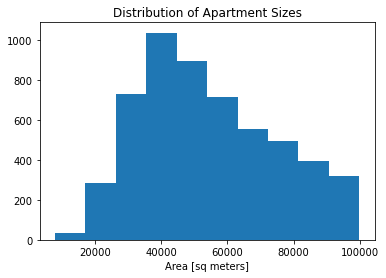

In [30]:
plt.hist(df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.title('Distribution of Apartment Sizes');

Scatter plot that shows apartment price as a function of apartment size

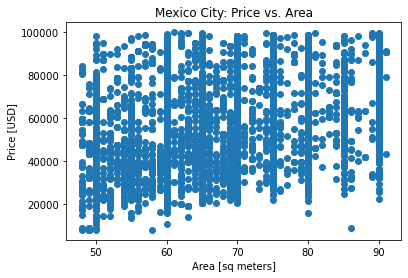

In [31]:
plt.scatter(df['surface_covered_in_m2'], df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
plt.title('Mexico City: Price vs. Area');

Mapbox scatter plot that shows the location of the apartments and represent their price using color

In [32]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split

Creation of future matrix and target vector

In [33]:
features = ['surface_covered_in_m2', 
            'lat', 
            'lon', 
            'borough']

target = 'price_aprox_usd'
X_train = df[features]
y_train = df[target]

In [34]:
X_train.head()

,surface_covered_in_m2,lat,lon,borough
0,57.0,23.634501,-102.552788,Benito Juárez
1,56.0,19.402413,-99.095391,Iztacalco
2,80.0,19.357820,-99.149406,Benito Juárez
3,60.0,19.504985,-99.208557,Azcapotzalco
4,50.0,19.354219,-99.126244,Coyoacán


Test data import

In [35]:
X_test = pd.read_csv('mexico_city_test_features.csv', delimiter='\t', encoding='latin1')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


## Modelling

### Baseline

In [36]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.53149826422
Baseline MAE: 17239.939475888295


In [45]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LinearRegression()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [46]:
y_test_pred = model.predict(X_test)

In [47]:
coefficients = model.named_steps['linearregression'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(sorted(coefficients), index=features)
feat_imp

surface_covered_in_m2            -14282.520368
lat                              -13400.891089
lon                               -6676.217197
borough_Benito Juárez             -6226.163491
borough_Iztacalco                 -5647.283325
borough_Azcapotzalco              -2486.167319
borough_Coyoacán                   -370.237325
borough_Álvaro Obregón              291.088836
borough_Iztapalapa                  385.010954
borough_Cuauhtémoc                  482.269297
borough_Tláhuac                     931.276706
borough_Miguel Hidalgo             1962.984604
borough_Venustiano Carranza        2446.320298
borough_Tlalpan                    3265.142292
borough_Gustavo A. Madero          3730.604024
borough_Xochimilco                 9748.916152
borough_La Magdalena Contreras    10354.803035
borough_Cuajimalpa de Morelos     13778.254729
dtype: float64

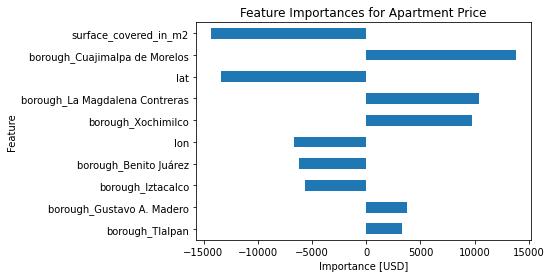

In [48]:
feat_imp.sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importances for Apartment Price");

### Ridge model

In [49]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [50]:
y_test_pred = model.predict(X_test)

Creatng a Series named feat_imp. The index contain the names of all the model features considers when making predictions

In [51]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(sorted(coefficients), index=features)
feat_imp

surface_covered_in_m2            -14166.869486
lat                              -13349.017448
lon                               -6637.429757
borough_Benito Juárez             -5925.666450
borough_Iztacalco                 -5609.918629
borough_Azcapotzalco              -2492.221814
borough_Coyoacán                   -350.531990
borough_Álvaro Obregón              291.654156
borough_Iztapalapa                  405.403127
borough_Cuauhtémoc                  478.901375
borough_Tláhuac                     929.857400
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza        2459.288646
borough_Tlalpan                    3275.121061
borough_Gustavo A. Madero          3737.561001
borough_Xochimilco                 9157.269123
borough_La Magdalena Contreras    10319.429804
borough_Cuajimalpa de Morelos     13778.188880
dtype: float64

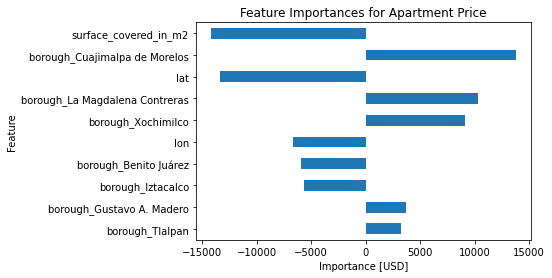

In [52]:
feat_imp.sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importances for Apartment Price");